In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Mounted at /content/drive


In [2]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/DIG Historical Data 1_6.csv')

In [3]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

# time_step = 100
# X_train, y_train = create_dataset(train_data, time_step)
# X_test, ytest = create_dataset(test_data, time_step)
time_step = 100

x, y = create_dataset(df1, time_step)

X_train = x[:train_size-100]
X_test = x[train_size-100:]
y_train = y[:train_size-100]
ytest = y[train_size-100:]

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
16/16 [==============================] - 6s 168ms/step - loss: 0.0319 - val_loss: 0.0036
Epoch 2/100
16/16 [==============================] - 1s 61ms/step - loss: 0.0037 - val_loss: 7.2493e-04
Epoch 3/100
16/16 [==============================] - 1s 63ms/step - loss: 0.0012 - val_loss: 2.0938e-04
Epoch 4/100
16/16 [==============================] - 1s 62ms/step - loss: 7.0268e-04 - val_loss: 2.0034e-04
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 6.3862e-04 - val_loss: 2.2998e-04
Epoch 6/100
16/16 [==============================] - 1s 60ms/step - loss: 6.1545e-04 - val_loss: 1.9001e-04
Epoch 7/100
16/16 [==============================] - 1s 62ms/step - loss: 5.8723e-04 - val_loss: 2.1749e-04
Epoch 8/100
16/16 [==============================] - 1s 61ms/step - loss: 5.5406e-04 - val_loss: 1.8208e-04
Epoch 9/100
16/16 [==============================] - 1s 63ms/step - loss: 5.3193e-04 - val_loss: 1.7878e-04
Epoch 10/100
16/16 [=======================

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

15/15 [==============================] - 0s 12ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 25252.17519907185


In [14]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_pred, ytest)
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))*100
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing MAPE: 99.99911791152165
Testing MAE: 24175.234215206652


In [15]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.2309093177318573], [0.231125146150589], [0.23138105869293213], [0.23166292905807495], [0.2319633662700653], [0.23227787017822266], [0.23260337114334106], [0.23293772339820862], [0.23327943682670593], [0.2336273491382599], [0.23398059606552124], [0.23433861136436462], [0.23470082879066467], [0.23506700992584229], [0.2354368269443512], [0.23581016063690186], [0.23618671298027039], [0.23656654357910156], [0.23694941401481628], [0.23733535408973694], [0.23772430419921875], [0.23811617493629456], [0.23851105570793152], [0.2389088273048401], [0.23930951952934265], [0.23971307277679443], [0.2401195764541626], [0.24052894115447998], [0.24094119668006897], [0.24135643243789673], [0.24177446961402893], [0.24219545722007751], [0.2426193654537201], [0.24304619431495667], [0.24347594380378723], [0.24390855431556702], [0.24434417486190796], [0.2447827160358429], [0.2452242374420166], [0.24566861987113953], [0.24611598253250122], [0.2465662956237793], [0.24701952934265137], [0.2474757432937622], 

In [16]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[27744.2249599 ],
       [27763.99590061],
       [27787.43874346],
       [27813.25945007],
       [27840.78097083],
       [27869.59106989],
       [27899.40855325],
       [27930.03685812],
       [27961.33948257],
       [27993.20995508],
       [28025.56910452],
       [28058.36506017],
       [28091.54595129],
       [28125.08993756],
       [28158.96698855],
       [28193.16618413],
       [28227.66022389],
       [28262.45456791],
       [28297.52737589],
       [28332.88137785],
       [28368.51111374],
       [28404.40839342],
       [28440.58140702],
       [28477.01923438],
       [28513.72460553],
       [28550.69206041],
       [28587.92978913],
       [28625.42960156],
       [28663.19422776],
       [28701.23185783],
       [28739.52611155],
       [28778.0906391 ],
       [28816.92271045],
       [28856.0223256 ],
       [28895.38948455],
       [28935.01872722],
       [28974.92370381],
       [29015.09622419],
       [29055.54174845],
       [29096.24935643],


In [17]:
# Append the last 100 values of test_data to the beginning of y_pred
last_100_test_data = scaler.inverse_transform(test_data[:101])
y_pred_with_test_data = np.append(last_100_test_data, y_pred)

In [18]:
print(y_pred_with_test_data.shape)
test_data.shape

(580,)


(480, 1)

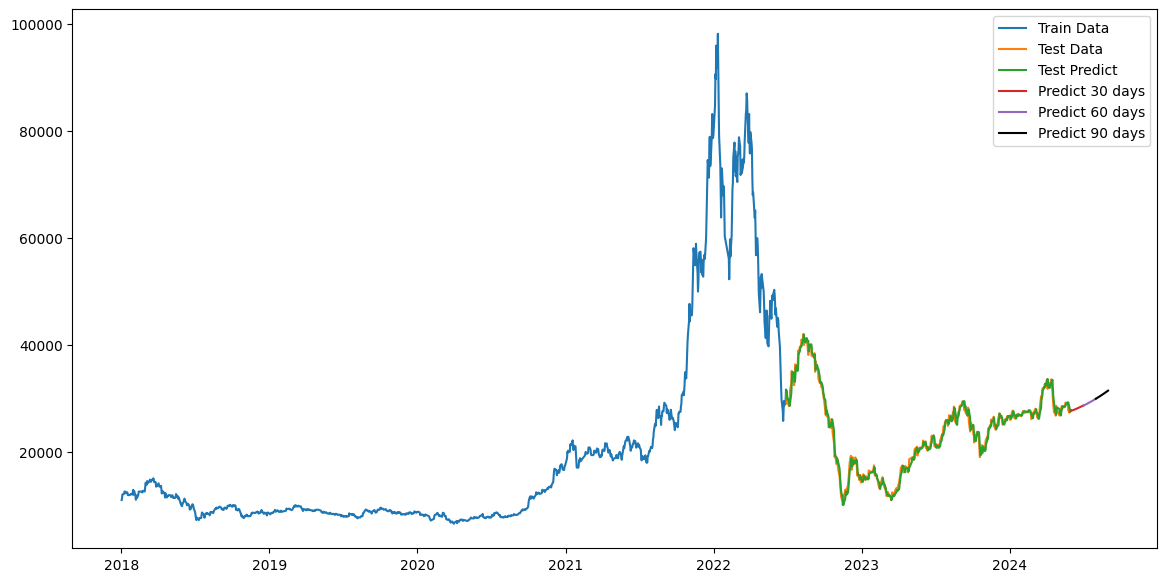

In [20]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data with appended last 100 test data
plt.plot(df['Date'][train_size:train_size + len(y_pred)], y_pred, label='Test Predict')

# Plot future predictions
last_test_date = df['Date'].iloc[-1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=30)
future_predict_dates_1 = pd.date_range(start=last_test_date + pd.Timedelta(days=31), periods=31)
future_predict_dates_2 = pd.date_range(start=last_test_date + pd.Timedelta(days=61), periods=31)

plt.plot(future_predict_dates, future_predict[0:30], label='Predict 30 days')
plt.plot(future_predict_dates_1, future_predict[29:60], label='Predict 60 days')
plt.plot(future_predict_dates_2, future_predict[59:90], label='Predict 90 days', color='black')
# Display the legend
plt.legend()

# Display the plot
plt.show()